In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# df = pd.read_csv("Online-Retail-DataSet.csv")

df = pd.read_excel('Online-Retail-DataSet.xlsx', sheet_name='Online-Retail-DataSet')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
# Checking the number of unique values of each column

df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [7]:
# Check for missing values
print("Missing values before handling:")
df.isnull().sum()

Missing values before handling:


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
## Missing values Analysis

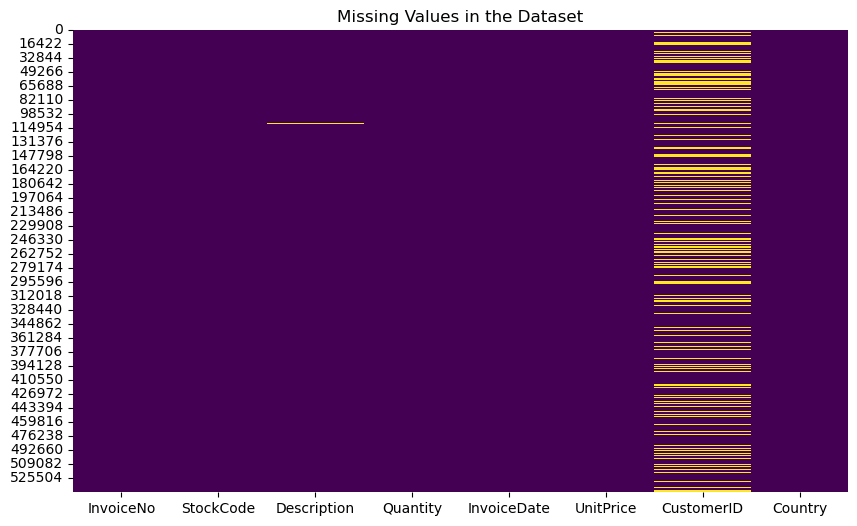

In [9]:
# Check for missing values
missing_values = df.isnull().sum()

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in the Dataset')
plt.show()

In [10]:
# 'CustomerID' is crucial for customer-level analysis (like CLV), so dropping rows with missing CustomerID to ensure data integrity
df = df.dropna(subset=['CustomerID'])

# The 'Description' field is important for product-level analysis, and since the number of missing values is small, we choose to drop these rows.
df = df.dropna(subset=['Description'])

# Checking missing values after handling
print("Missing values after handling:")
print(df.isnull().sum())


Missing values after handling:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [11]:
# Remove duplicate rows to avoid data redundancy in our analysis.
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")

Number of duplicate rows: 5225
Number of duplicate rows after removal: 0


## Feature Engineering

In [12]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a total sales column
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

In [13]:
import datetime as dt

# Calculate the Recency, Frequency, and Monetary value for each customer
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm_table = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSales': 'sum'
})

# Rename columns to Recency, Frequency, and Monetary
rfm_table.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)


In [14]:
## Creating RFM table

# Calculate Average Order Value
rfm_table['AvgOrderValue'] = rfm_table['Monetary'] / rfm_table['Frequency']

# Calculate Purchase Frequency
purchase_frequency = sum(rfm_table['Frequency']) / rfm_table.shape[0]

# Calculate Repeat Rate and Churn Rate
repeat_rate = rfm_table[rfm_table['Frequency'] > 1].shape[0] / rfm_table.shape[0]
churn_rate = 1 - repeat_rate

# Calculate Profit Margin (assumed to be 5% for this example)
rfm_table['ProfitMargin'] = rfm_table['Monetary'] * 0.05

# Calculate CLV
rfm_table['CLV'] = (rfm_table['AvgOrderValue'] * purchase_frequency) / churn_rate


## EDA

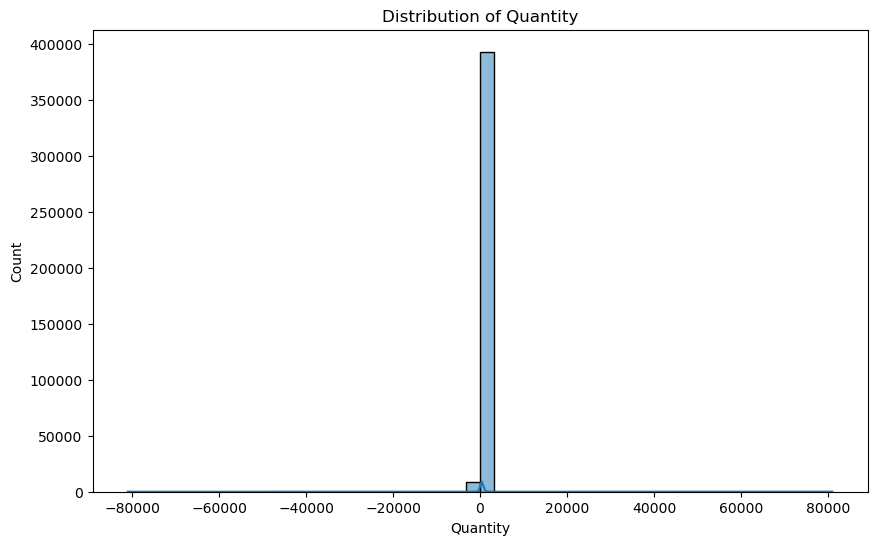

In [15]:
# Distribution of Quantity
plt.figure(figsize=(10, 6))
sns.histplot(df['Quantity'], kde=True, bins=50)
plt.title('Distribution of Quantity')
plt.show()

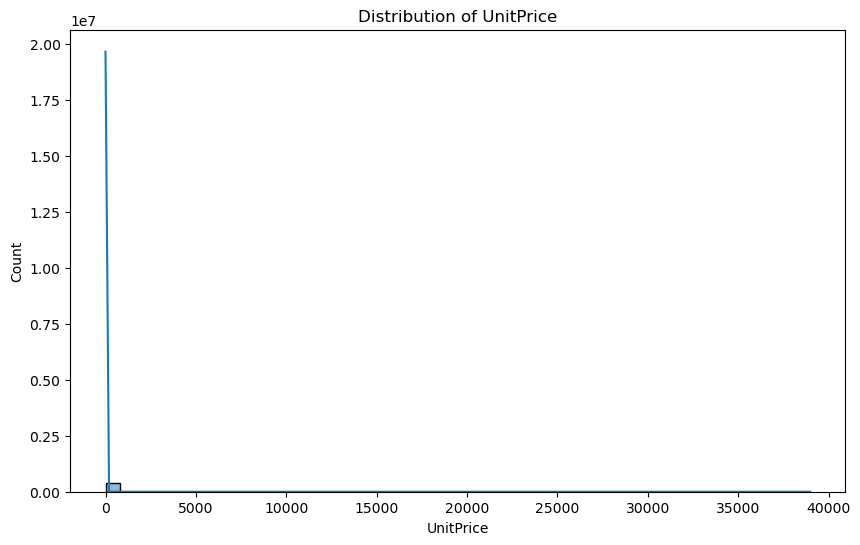

In [16]:
# Distribution of UnitPrice

plt.figure(figsize=(10, 6))
sns.histplot(df['UnitPrice'], kde=True, bins=50)
plt.title('Distribution of UnitPrice')
plt.show()

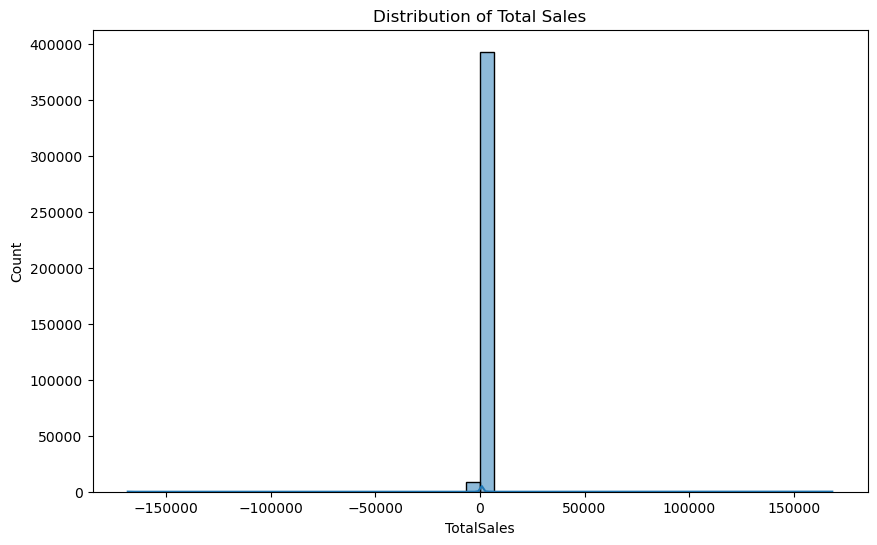

In [17]:
# Distribution of TotalSales

plt.figure(figsize=(10, 6))
sns.histplot(df['TotalSales'], kde=True, bins=50)
plt.title('Distribution of Total Sales')
plt.show()

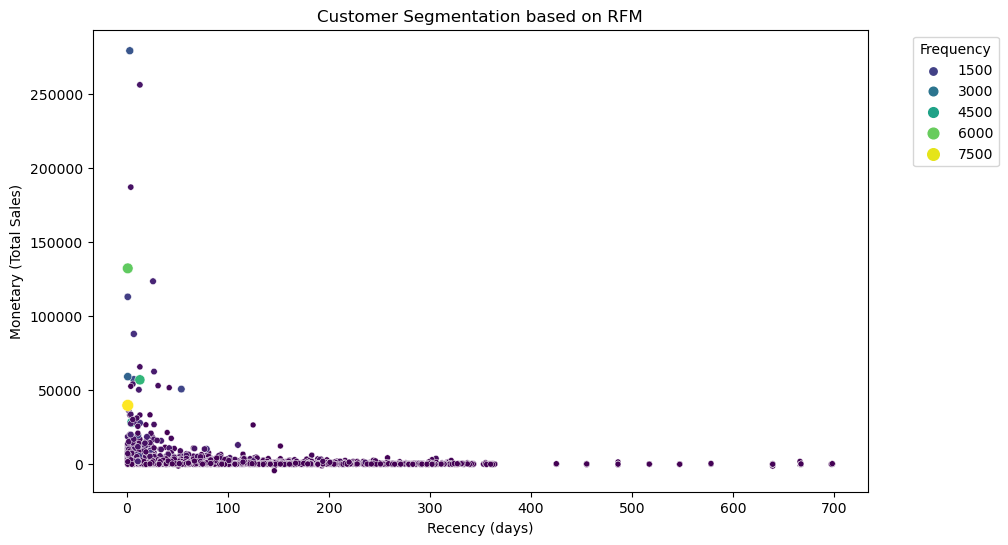

In [18]:
## Customer Segmentation Analysis

# RFM Segmentation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', size='Frequency', hue='Frequency', data=rfm_table, palette='viridis')
plt.title('Customer Segmentation based on RFM')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary (Total Sales)')
plt.legend(title='Frequency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


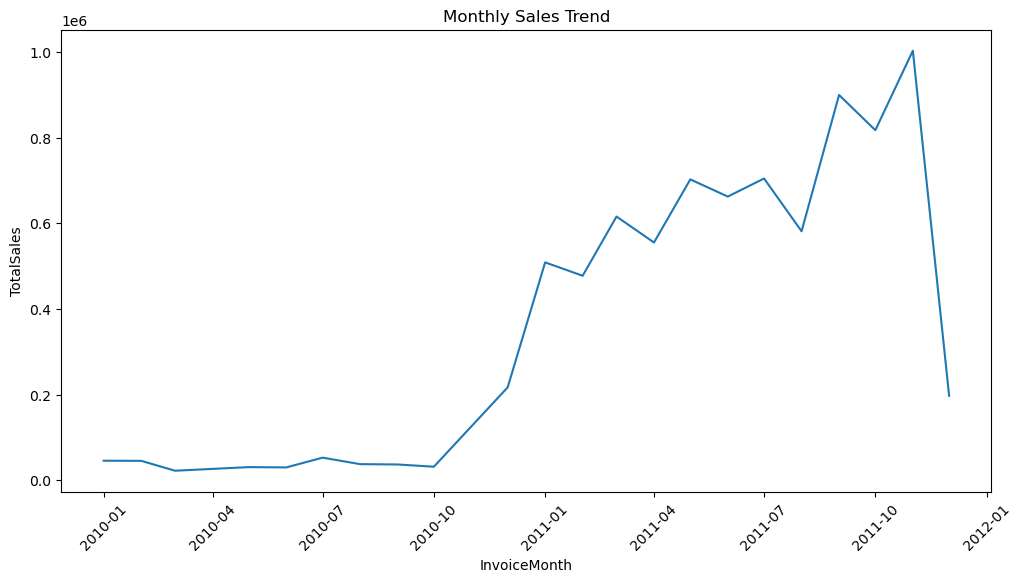

In [19]:
## Time Series Analysis

# Extract Month and Year from InvoiceDate
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Create the monthly_sales DataFrame
monthly_sales = df.groupby('InvoiceMonth')['TotalSales'].sum().reset_index()

# Convert InvoiceMonth to datetime (timestamp) for Matplotlib
monthly_sales['InvoiceMonth'] = monthly_sales['InvoiceMonth'].dt.to_timestamp()

# Plotting the monthly sales trend
plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceMonth', y='TotalSales', data=monthly_sales)
plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.show()

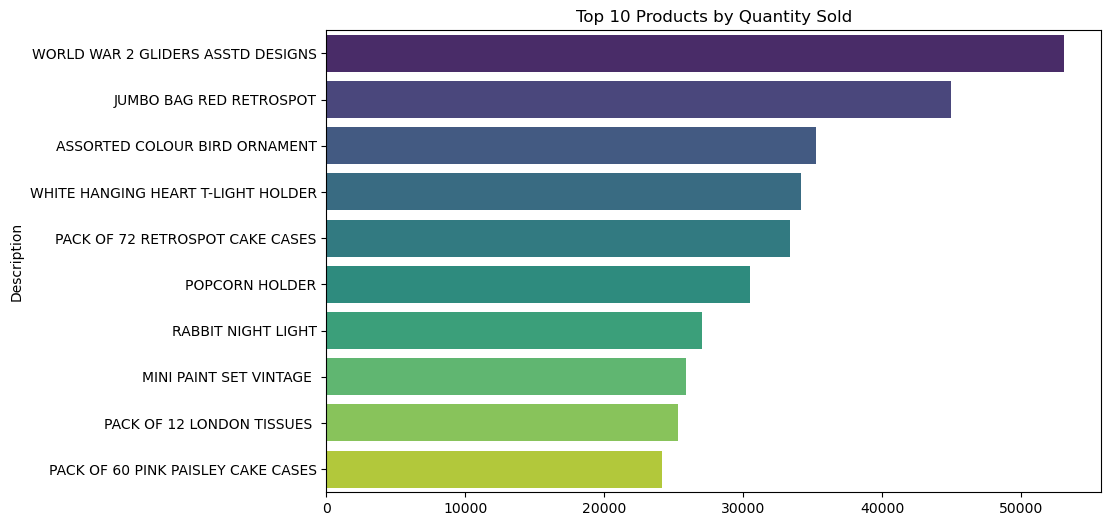

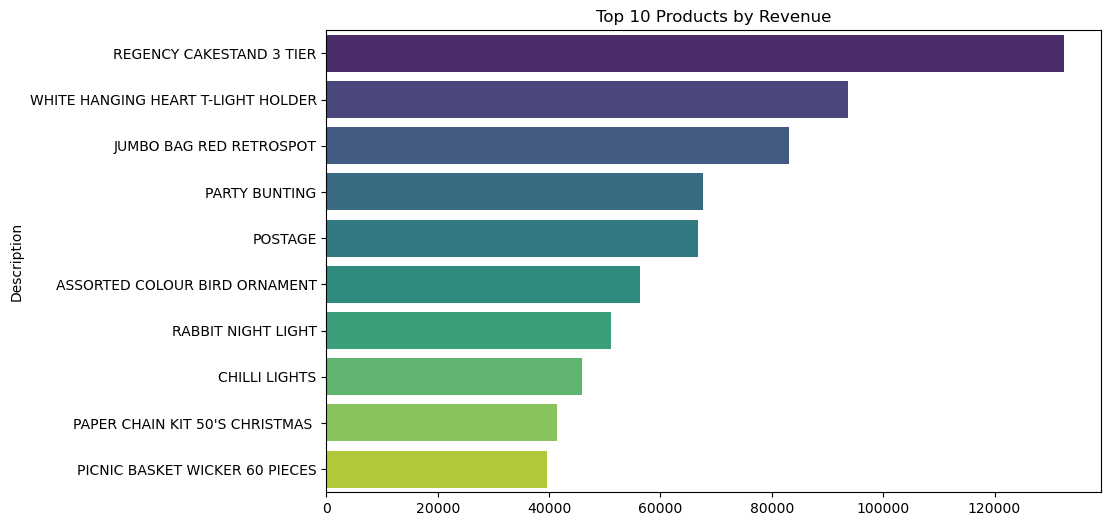

In [20]:
## Top Selling Products

# Top 10 Products by Quantity Sold
top_products_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_products_quantity.values, y=top_products_quantity.index, palette='viridis')
plt.title('Top 10 Products by Quantity Sold')
plt.show()

# Top 10 Products by Revenue
top_products_revenue = df.groupby('Description')['TotalSales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_products_revenue.values, y=top_products_revenue.index, palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.show()


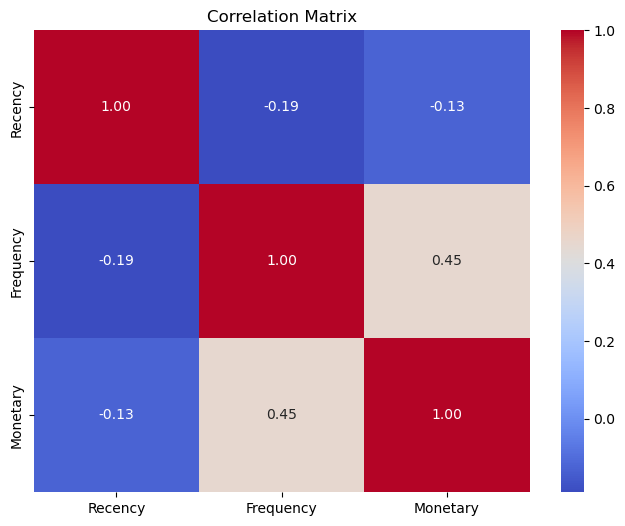

In [21]:
# Correlation matrix
corr_matrix = rfm_table[['Recency', 'Frequency', 'Monetary']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

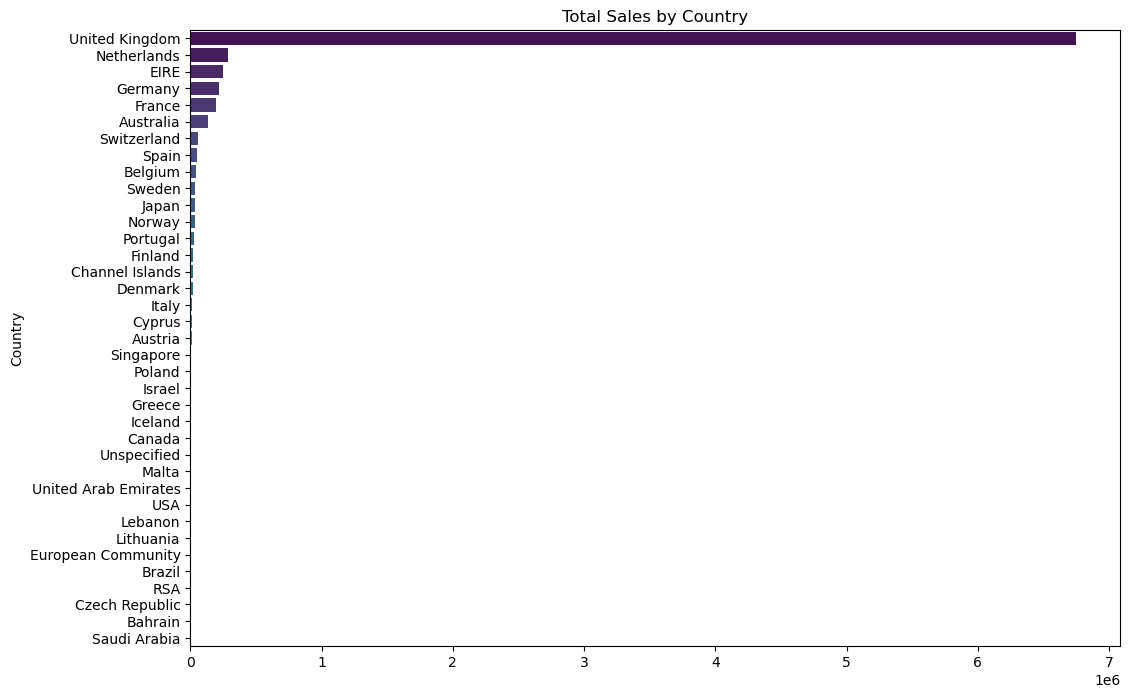

In [22]:
# Sales by Country
sales_by_country = df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=sales_by_country.values, y=sales_by_country.index, palette='viridis')
plt.title('Total Sales by Country')
plt.show()

In [23]:
## Calculate Customer Lifetime Value (CLV)

# Calculate Average Order Value
rfm_table['AvgOrderValue'] = rfm_table['Monetary'] / rfm_table['Frequency']

# Calculate Purchase Frequency
purchase_frequency = sum(rfm_table['Frequency']) / rfm_table.shape[0]

# Calculate Repeat Rate and Churn Rate
repeat_rate = rfm_table[rfm_table['Frequency'] > 1].shape[0] / rfm_table.shape[0]
churn_rate = 1 - repeat_rate

# Calculate Profit Margin (assumed to be 5% for this example)
rfm_table['ProfitMargin'] = rfm_table['Monetary'] * 0.05

# Calculate CLV
rfm_table['CLV'] = (rfm_table['AvgOrderValue'] * purchase_frequency) / churn_rate


In [24]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 6 numerical features : ['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'TotalSales', 'InvoiceMonth']

We have 4 categorical features : ['InvoiceNo', 'StockCode', 'Description', 'Country']


In [25]:
# Defining the features (X) and the target variable (y)
X = rfm_table[['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'ProfitMargin']]  # Features
y = rfm_table['CLV']  


In [26]:
X.head(3)

,Recency,Frequency,Monetary,AvgOrderValue,ProfitMargin
CustomerID,,,,,
12346.0,327,2,0.00,0.000000,0.000
12347.0,41,182,4310.00,23.681319,215.500
12348.0,77,31,1797.24,57.975484,89.862


In [27]:
y.head(3)

CustomerID
12346.0         0.000000
12347.0    120386.231743
12348.0    294723.876260
Name: CLV, dtype: float64

In [28]:
# # Create Column Transformer with 3 types of transformers
# num_features = X.select_dtypes(exclude="object").columns
# cat_features = X.select_dtypes(include="object").columns

# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer

# numeric_transformer = StandardScaler()
# oh_transformer = OneHotEncoder()

# preprocessor = ColumnTransformer(
#     [
#         ("OneHotEncoder", oh_transformer, cat_features),
#          ("StandardScaler", numeric_transformer, num_features),        
#     ]
# )

In [29]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape

((3497, 5), (875, 5))

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline


# Defining models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regression': SVR()
}

# Dictionary to store the evaluation metrics for each model
metrics = {}

# Function to calculate and store metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Iterate over each model
for model_name, model in models.items():
    # Building the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling the features
        ('model', model)
    ])
    
    # Training the model
    pipeline.fit(X_train, y_train)
    
    # Predicting on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculating metrics
    mse, rmse, mae, r2 = calculate_metrics(y_test, y_pred)
    
    # Storing the metrics
    metrics[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }


In [31]:
# Converting the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics).T

# Display the metrics DataFrame
print(metrics_df)

                                    MSE          RMSE           MAE        R²
Linear Regression          1.925124e-18  1.387488e-09  2.785130e-10  1.000000
Ridge Regression           5.281439e+04  2.298138e+02  4.152421e+01  1.000000
Lasso Regression           6.875273e+01  8.291726e+00  2.772931e+00  1.000000
Decision Tree              2.214126e+10  1.487994e+05  9.041329e+03  0.964513
Random Forest              4.832009e+10  2.198183e+05  1.010506e+04  0.922554
Gradient Boosting          2.725476e+10  1.650902e+05  1.152529e+04  0.956317
Support Vector Regression  6.330094e+11  7.956189e+05  1.309627e+05 -0.014568


In [32]:
# Find the best model based on the lowest RMSE
best_model_name = metrics_df['RMSE'].idxmin()
best_model_rmse = metrics_df.loc[best_model_name, 'RMSE']

print(f"The best model is {best_model_name} with an RMSE of {best_model_rmse: }")

# Optionally, if you want to see the complete metrics for the best model
best_model_metrics = metrics_df.loc[best_model_name]
print("\nComplete metrics for the best model:")
print(best_model_metrics)


The best model is Linear Regression with an RMSE of  1.3874883338762953e-09

Complete metrics for the best model:
MSE     1.925124e-18
RMSE    1.387488e-09
MAE     2.785130e-10
R²      1.000000e+00
Name: Linear Regression, dtype: float64


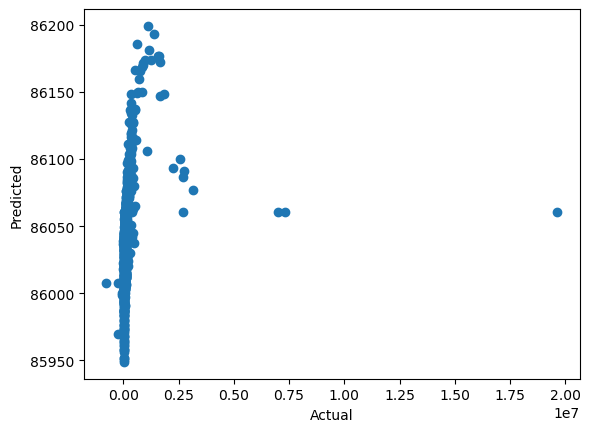

In [33]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

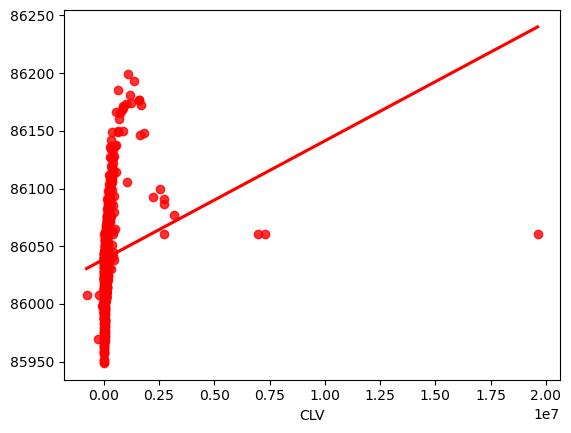

In [34]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

## Difference between Actual and Predicted Values

In [35]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
CustomerID,,,
15079.0,94645.946899,86052.384395,8593.562503
12930.0,77176.502391,86042.753288,-8866.250897
12956.0,28914.952885,86011.484785,-57096.531900
12904.0,35517.860624,86032.215450,-50514.354826
17411.0,88542.037021,86055.652398,2486.384623
...,...,...,...
13310.0,71542.025731,86040.739444,-14498.713714
12417.0,91884.694745,86027.517142,5857.177603
15489.0,100750.381616,86058.410688,14691.970928


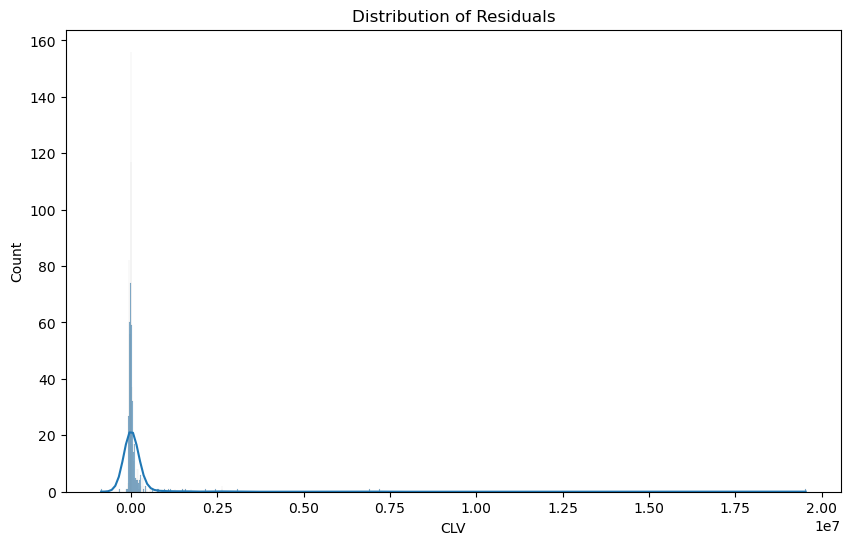

In [36]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

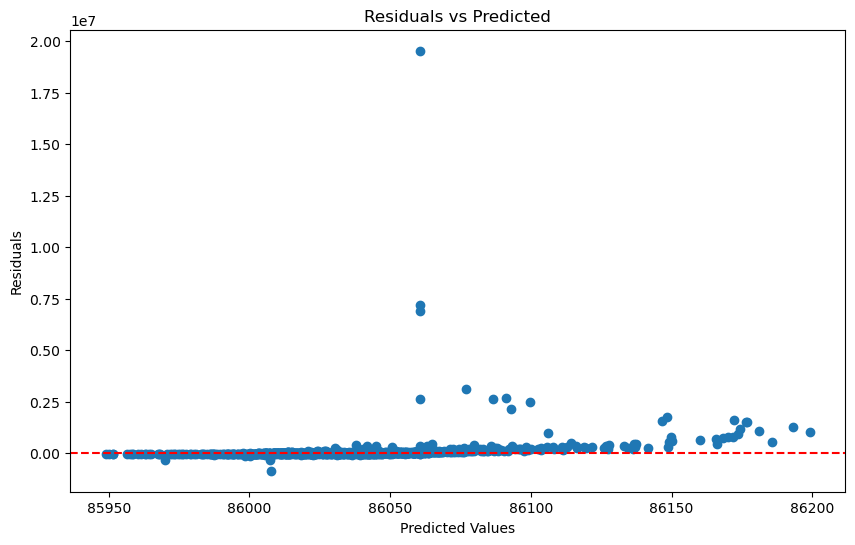

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [38]:
import joblib

# Saving the model
joblib.dump(best_model_name, 'best_clv_model.pkl')

['best_clv_model.pkl']